<a href="https://colab.research.google.com/github/Frankson18/A-Hybrid-Method-for-Movie-Recommendation/blob/main/A-Hybrid-Method-for-Movie-Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalações, imports e extração dos dados

In [1]:
!pip install kaggle --upgrade --quiet
!pip install scikit-surprise --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import os
import json
import pandas as pd
import numpy as np
import re
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import nltk
%matplotlib inline
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
### Configuração de autenticação na base do kaggle

# Credenciais do Kaggle (API Key e Username)
kaggle_creds = {
    "username": "<username_kagle>",
    "key": "<key_kagle>"
}

# Cria a pasta kaggle
!mkdir -p ~/.kaggle

# Salva o arquivo kaggle.json
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_creds, f)

# Define permissões adequadas para o arquivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
### Download dos datasets

# Link da fonte no kaggle
# "https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset"

# Download do dataset movies_metadata.csv
!kaggle datasets download -d rounakbanik/the-movies-dataset -f movies_metadata.csv

!unzip "/content/movies_metadata.csv.zip"

!rm -f movies_metadata.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
movies_metadata.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/movies_metadata.csv.zip
replace movies_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: movies_metadata.csv     


In [17]:
# Download do dataset keywords.csv.csv
!kaggle datasets download -d rounakbanik/the-movies-dataset -f keywords.csv

!unzip "/content/keywords.csv.zip"

!rm -f keywords.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 126MB/s]
Archive:  /content/keywords.csv.zip
  inflating: keywords.csv            


In [18]:
# Download do dataset ratings.csv.csv
!kaggle datasets download -d rounakbanik/the-movies-dataset -f ratings.csv

!unzip "/content/ratings.csv.zip"

!rm -f ratings.csv.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
 90% 153M/170M [00:00<00:00, 170MB/s]
100% 170M/170M [00:01<00:00, 169MB/s]
Archive:  /content/ratings.csv.zip
  inflating: ratings.csv             


#Pre-processamento

In [19]:
dfMoviesMetadata = pd.read_csv("/content/movies_metadata.csv")
dfMoviesMetadata['id'] = dfMoviesMetadata['id'].astype(str)
dfKeyWords = pd.read_csv("/content/keywords.csv")
dfKeyWords['id'] = dfKeyWords['id'].astype(str)
dfRatings = pd.read_csv("/content/ratings.csv")
dfRatings['movieId'] = dfRatings['movieId'].astype(str)
dfRatings['userId'] = dfRatings['userId'].astype(str)

<ipython-input-19-c510d927793d>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  dfMoviesMetadata = pd.read_csv("/content/movies_metadata.csv")


In [20]:
dfMoviesMetadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [21]:
dfMoviesMetadata.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


In [22]:
dfKeyWords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [23]:
dfKeyWords.describe()

,id,keywords
count,46419,46419
unique,45432,25989
top,141971,[]
freq,3,14795


In [24]:
dfRatings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [25]:
dfRatings.describe()

,rating,timestamp
count,2.602429e+07,2.602429e+07
mean,3.528090e+00,1.171258e+09
std,1.065443e+00,2.052889e+08
min,5.000000e-01,7.896520e+08
25%,3.000000e+00,9.907545e+08
50%,3.500000e+00,1.151716e+09
75%,4.000000e+00,1.357578e+09
max,5.000000e+00,1.501830e+09


In [26]:
def process_keywords_column(df):
    lista_da_lista_de_keywords_por_linha = []

    for index, keywords in enumerate(df['keywords']):

        if pd.isna(keywords) or keywords == '':
            lista_da_lista_de_keywords_por_linha.append('')  # Adiciona uma string vazia
            continue

        # Usar regex para encontrar todos os nomes na string
        names = re.findall(r"'name': '([^']*)'", keywords)

        # Juntar os nomes em uma string
        keywords_string = ' '.join(names)

        # Adicionar à lista final
        lista_da_lista_de_keywords_por_linha.append(keywords_string.strip())  # Remove espaços em branco

    # Atualiza a coluna 'keywords' do DataFrame
    df['keywords'] = lista_da_lista_de_keywords_por_linha

    return df

In [27]:
dfKeyWords=process_keywords_column(dfKeyWords)

In [28]:
dfKeyWords.head()

,id,keywords
0,862,jealousy toy boy friendship friends rivalry bo...
1,8844,board game disappearance new home recluse gian...
2,15602,fishing best friend duringcreditsstinger old men
3,31357,based on novel interracial relationship single...
4,11862,baby midlife crisis confidence aging daughter ...


In [29]:
select_columns = ["id", "genres", "title", "overview","tagline"]
dfMoviesMetadata = dfMoviesMetadata[select_columns]

In [30]:
def process_genres_column(df):
    lista_da_lista_de_generos_por_linha = []

    for generos in df['genres']:
        # Corrigir aspas simples para aspas duplas
        lista_generos = generos.replace("'", '"')
        # Convertendo a string para uma lista de dicionários
        lista = json.loads(lista_generos)

        # Gerar uma string de gêneros concatenados
        generos_string = ' '.join(genero.get("name") for genero in lista)

        # Adicionar à lista final
        lista_da_lista_de_generos_por_linha.append(generos_string)

    # Atualiza a coluna 'genres' do DataFrame
    df['genres'] = lista_da_lista_de_generos_por_linha

    return df

In [31]:
dfMoviesMetadata = process_genres_column(dfMoviesMetadata)

In [32]:
dfMerged = pd.merge(dfMoviesMetadata, dfKeyWords, on='id', how='left')

In [33]:
dfMerged = dfMerged.dropna()

In [34]:
dfMerged.shape

(20717, 6)

In [35]:
dfMerged.drop_duplicates(inplace=True)

In [36]:
dfMerged.shape

(20393, 6)

In [37]:
# Supondo que df seja o seu DataFrame
# Separar os gêneros em múltiplas linhas
df_exploded = dfMerged.assign(genres=dfMerged['genres'].str.split()).explode('genres')

# Número de amostras que você quer por gênero
n_samples_per_genre = 3000

# Aplicar a amostragem uniforme por gênero
uniform_sample = df_exploded.groupby('genres').apply(lambda x: x.sample(n=min(len(x), n_samples_per_genre), random_state=42)).reset_index(drop=True)

# Agora agrupar os filmes novamente, combinando os gêneros originais
# Agrupar por 'id' e combinar de volta os gêneros
dfMerged = uniform_sample.groupby(['id', 'title', 'overview', 'tagline', 'keywords']).agg({
    'genres': lambda x: ' '.join(x)
}).reset_index()

# Exibir o dataset com os gêneros juntos novamente
dfMerged

<ipython-input-37-2a45dc2df155>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  uniform_sample = df_exploded.groupby('genres').apply(lambda x: x.sample(n=min(len(x), n_samples_per_genre), random_state=42)).reset_index(drop=True)


,id,title,overview,tagline,keywords,genres
0,100,"Lock, Stock and Two Smoking Barrels",A card sharp and his unwillingly-enlisted frie...,A Disgrace to Criminals Everywhere.,ambush alcohol shotgun tea joint machismo cock...,Crime
1,10001,Young Einstein,Albert Einstein is the son of a Tasmanian appl...,E=mc²,atomic bomb nobel prize rock albert einstein m...,Fiction Science
2,100010,Flight Command,"A rookie flyer, Ens. Alan Drake, joins the fam...","T-H-R-I-L-L AMERICA! Here come The Flying ""HEL...",pilot navy,War
3,100024,Bloodwork,A couple of college students decide to sign up...,Not Dying Doesn't Mean You're Alive,dangerous side effects clinical trials allergy...,Horror Thriller
4,10003,The Saint,"Ivan Tretiak, Russian Mafia boss who wants to ...",Never reveal your name. Never turn your back. ...,berlin russia gas master thief the saint,Adventure Fiction Romance Science Thriller
...,...,...,...,...,...,...
17702,99920,Confessions of a Nazi Spy,FBI agent Ed Renard investigates the pre-War e...,Trapped!,nazi spy,Drama War
17703,9993,Little Fish,Set in the Little Saigon district outside of S...,The past is right here,bank junkie heroin sydney drug dealing drug,Crime Drama
17704,9994,The Great Mouse Detective,When the diabolical Professor Ratigan kidnaps ...,London's crime-fighting ace on his most baffli...,london england detective queen sherlock holmes...,Animation Comedy Family
17705,9995,Turn It Up,Trying to bootstrap his way out of Brooklyn's ...,How you gonna win?,single parent rap music loss of mother sociall...,Action Crime Drama


In [38]:
dfRatings = dfRatings[dfRatings['movieId'].isin(dfMerged['id'])]

In [39]:
df=dfMerged.copy()
dfRatings= dfRatings[0:1000000]

In [40]:
def remove_punc(text):
    cleaned = text.translate(str.maketrans('','', string.punctuation)).lower().replace('nan','')
    clean_text = cleaned.translate(str.maketrans('','', string.digits))
    return clean_text

In [41]:
df['overview'] = df['overview'].astype(str)
df['title'] = df['title'].astype(str)
df['tagline'] = df['tagline'].astype(str)
df['keywords'] = df['keywords'].astype(str)
df['genres'] = df['genres'].apply(remove_punc)
df['overview'] = df['overview'].apply(remove_punc)
df['tagline'] = df['tagline'].apply(remove_punc)
df['title'] = df['title'].apply(remove_punc)
df['keywords'] = df['keywords'].apply(remove_punc)

In [42]:
df['bag_of_words'] = ''
df['bag_of_words'] = df[['title','genres','keywords','overview']].apply(lambda x: ' '.join(x), axis=1)

df.head()

,id,title,overview,tagline,keywords,genres,bag_of_words
0,100,lock stock and two smoking barrels,a card sharp and his unwillinglyenlisted frien...,a disgrace to criminals everywhere,ambush alcohol shotgun tea joint machismo cock...,crime,lock stock and two smoking barrels crime ambus...
1,10001,young einstein,albert einstein is the son of a tasmanian appl...,emc²,atomic bomb nobel prize rock albert einstein m...,fiction science,young einstein fiction science atomic bomb nob...
2,100010,flight command,a rookie flyer ens alan drake joins the famous...,thrill america here come the flying hell cats,pilot navy,war,flight command war pilot navy a rookie flyer e...
3,100024,bloodwork,a couple of college students decide to sign up...,not dying doesnt mean youre alive,dangerous side effects clinical trials allergy...,horror thriller,bloodwork horror thriller dangerous side effec...
4,10003,the saint,ivan tretiak russian mafia boss who wants to c...,never reveal your name never turn your back ne...,berlin russia gas master thief the saint,adventure fiction romance science thriller,the saint adventure fiction romance science th...


In [43]:
df[df['id']=='14919']

,id,title,overview,tagline,keywords,genres,bag_of_words
3054,14919,batman mask of the phantasm,an old flame of bruce waynes strolls into town...,the dark knight fights to save gotham city fro...,dc comics based on comic super powers,action adventure animation family,batman mask of the phantasm action adventure a...


In [44]:
# Converta a coluna 'userId' e 'id' para numérico
dfRatings['userId'] = pd.to_numeric(dfRatings['userId'], errors='coerce')
dfRatings['movieId'] = pd.to_numeric(dfRatings['movieId'], errors='coerce')

# Converta a coluna 'rating' para numérico
dfRatings['rating'] = pd.to_numeric(dfRatings['rating'], errors='coerce')

# Remova quaisquer linhas que tenham NaN após a conversão
dfRatings = dfRatings.dropna(subset=['userId', 'movieId', 'rating'])

#Preparação dos modelos

In [45]:
# Como os textos estão em inglês, cria-se um objeto para o stemmer nessa língua.
stemmer = SnowballStemmer("english")

In [46]:
def tokenize_and_stem(text):

    # tokeniza por setença e depois por palavra
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # stemmiza os tokens
    stems = [stemmer.stem(token) for token in tokens]

    return stems

In [47]:
tfidf = TfidfVectorizer(stop_words='english',tokenizer=tokenize_and_stem, min_df=5)

In [48]:
tfidf_matrix = tfidf.fit_transform([x for x in df["bag_of_words"]])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev'

In [49]:
tfidf_matrix.shape

(17707, 9964)

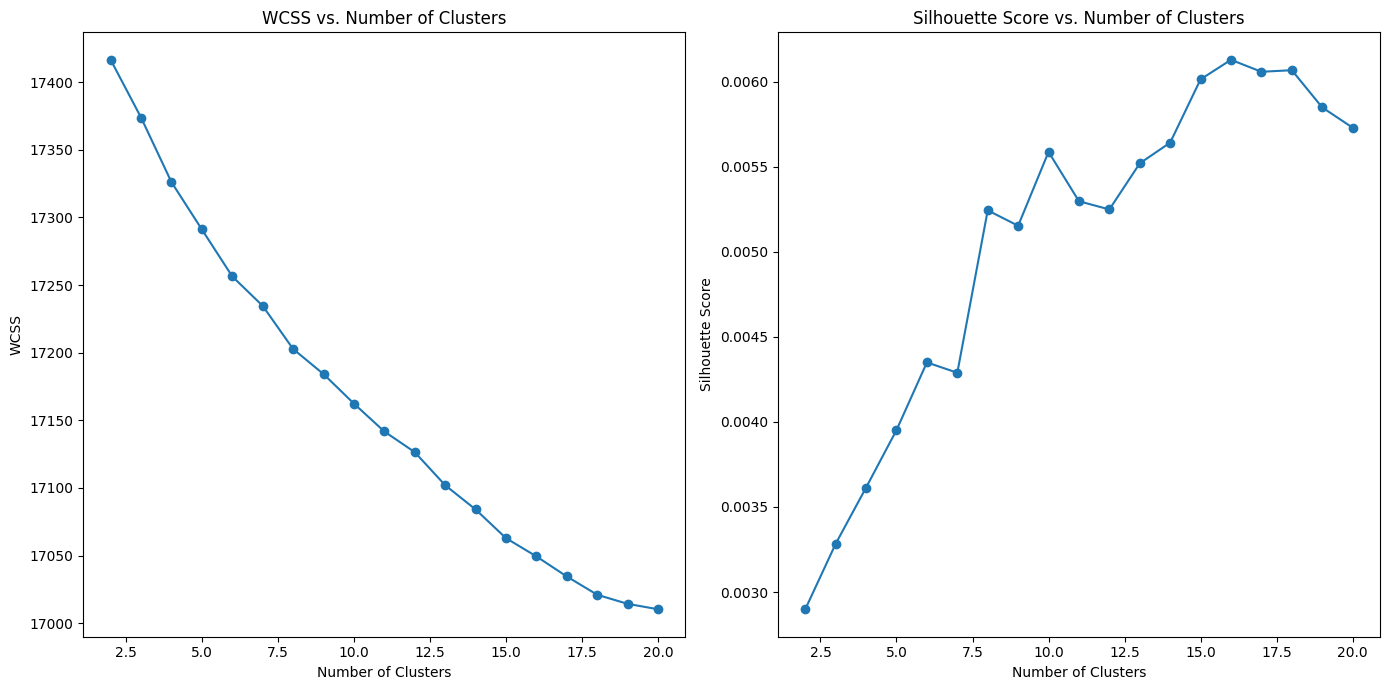

In [50]:
# Função para calcular o erro quadrático médio por cluster (Within-Cluster Sum of Square) e o índice Silhouette
def calculate_wcss(data):
    wcss = []
    silhouette_scores = []
    # Varia o número de grupos
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, n_init='auto', random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    return wcss, silhouette_scores

# Calcula os índices
wcss, silhouette_scores = calculate_wcss(tfidf_matrix)

# Realiza a plotagem dos índices
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(range(2, 21), wcss, marker='o')
plt.title('WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range(2, 21), silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [51]:
# Realiza o agrupamento dos dados
kmeans = KMeans(n_clusters=18, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Adiciona uma coluna com os grupos
df['cluster'] = clusters

In [53]:
def get_cluster_representative_dfs(cluster_centers, X_tfidf, df, n=5):
    dataframes = []

    # Itera sobre cada centroide
    for cluster_center in cluster_centers:
        # Calcula a distância entre cada filme e o centróide
        distances = np.dot(X_tfidf, cluster_center.T)
        # Pega os índices dos filmes mais próximos do centróide
        closest_indices = distances.argsort()[-n:][::-1]

        # Cria um DataFrame com os dados dos filmes mais próximos
        closest_movies_df = df.iloc[closest_indices]

        # Adiciona o DataFrame à lista
        dataframes.append(closest_movies_df)

    return dataframes

# Exemplo de uso
representative_dfs = get_cluster_representative_dfs(kmeans.cluster_centers_, tfidf_matrix.toarray(), df, n=5)

# Exibir os DataFrames de cada cluster
for i, cluster_df in enumerate(representative_dfs):
    print(f"Cluster {i+1} representative movies:")
    display(cluster_df[['title', 'overview', 'genres']]) # Exibir as colunas desejadas

Cluster 1 representative movies:


,title,overview,genres
1158,midway,this war drama depicts the us and japanese for...,history war
8446,the secret of santa vittoria,during world war ii italian villagers hide the...,war
13331,the biggest battle,a story of how world war ii affected the lives...,war
16365,enemy at the gates,enemy at the gates is a war film from jeanjacq...,war
10878,rangoon,love triangle set against the backdrop of worl...,drama history romance war


Cluster 2 representative movies:


,title,overview,genres
8628,modern vampires,a vampire hunter in southern california discov...,action romance thriller
14789,an american vampire story,a group of friends go on a vacation with some ...,comedy horror
13163,vampires the turning,an american muaythai fighter in thailand must ...,action adventure horror
1495,horror of dracula,after jonathan harker attacks dracula at his c...,horror
1561,vampire hookers,this horror film revolves around a sinister va...,foreign horror


Cluster 3 representative movies:


,title,overview,genres
16987,high school high,richard clark has just left the wellknown well...,comedy
9646,fist fight,when one school teacher gets the other fired h...,comedy
10768,mamaboy,a high school student must hide the fact that ...,comedy family fantasy fiction romance science
7592,slaughter high,eight different people are invited to their ye...,horror
3372,the spectacular now,a hardpartying high school seniors philosophy ...,comedy romance


Cluster 4 representative movies:


,title,overview,genres
2357,the scorpion king rise of a warrior,the heroic tale of young mathayus and his rele...,action adventure fantasy
17368,flyboys,the adventures of the lafayette escadrille you...,action adventure drama history romance war
6003,in the name of the king a dungeon siege tale,a man named farmer sets out to rescue his kidn...,adventure drama fantasy
5993,inkheart,the adventures of a father and his young daugh...,adventure family fantasy
2715,dragonball evolution,the young warrior son goku sets out on a quest...,action adventure fantasy fiction science thriller


Cluster 5 representative movies:


,title,overview,genres
676,rise of the animals,in a world where animals have turned on humani...,adventure horror
13900,iria zeiram the animation,a monster hunter goes after a beast that could...,action animation fiction science
10470,dead fury,animated parody of such horror classics as evi...,action adventure animation comedy family horror
17004,the jungle book,the boy mowgli makes his way to the manvillage...,adventure animation family
10629,zookeeper,a comedy about a zookeeper who might be great ...,comedy family


Cluster 6 representative movies:


,title,overview,genres
6019,south central,a man is put to prison for years coming out o...,crime drama
5077,no good deed,while doing a friend a favor and searching for...,action crime drama mystery
17425,seconds,when an experienced thief accidentally makes o...,action crime thriller
7680,dillinger,the life of american public enemy number one w...,action crime
9511,shot caller,a newlyreleased prison gangster is forced by t...,crime drama thriller


Cluster 7 representative movies:


,title,overview,genres
13075,the apple,musical set in the future eg a young couple e...,fantasy fiction music science
11621,the idolmaker,based on the life of rock promoterproducer bob...,drama music romance
14002,once,a vacuum repairman moonlights as a street musi...,drama music romance
6609,the winding stream,the story of the american music dynasty the ca...,documentary family history music
6050,bandslam,a high school social outcast and the popular g...,family music


Cluster 8 representative movies:


,title,overview,genres
2056,the fitzgerald family christmas,the siblings of the fitzgerald family must dec...,family
16066,house at the end of the street,a mother and daughter move to a new town and f...,horror thriller
3182,this christmas,this year christmas with the whitfields promis...,comedy
9304,love the coopers,when four generations of the cooper clan come ...,family
6544,our mothers house,seven british children bury their mother and h...,drama


Cluster 9 representative movies:


,title,overview,genres
15056,manhattan,the life of a divorced television writer datin...,comedy drama romance
5878,three wise girls,romantic comedy drama about three friends in n...,comedy romance
4106,the other man,the story of a husband who suspects his wife o...,drama mystery romance thriller
8209,me before you,a small town girl is caught between deadend jo...,drama romance
7756,before we go,a woman who is robbed on her way to catch the ...,romance


Cluster 10 representative movies:


,title,overview,genres
6291,go west young lady,a young woman arrives in the western town of h...,comedy western
4557,gunslinger,after her husband is gunned down rose hood tak...,romance western
3140,ambush,a westerner searches for a white woman held by...,western
17318,vengeance,a man tracks down the five outlaws who murdere...,western
14810,a town called hell,a group of mexican revolutionaries murders a t...,action western


Cluster 11 representative movies:


,title,overview,genres
5135,training day,on his first day on the job as a narcotics off...,action crime drama thriller
1792,the last of the finest,an elite group of vice cops are fired from the...,action crime drama
881,drug war,the taciturn police commander zhang leads an u...,action crime
7213,hot pursuit,an uptight bythebook cop must protect the wido...,action crime
14546,trainspotting,renton deeply immersed in the edinburgh drug s...,crime drama


Cluster 12 representative movies:


,title,overview,genres
6851,frontera,after crossing the border illegally for work m...,western
12540,dr bronners magic soapbox,a human story about a socially responsible com...,documentary
11113,genius party,the seven short films making up genius party c...,animation
6545,she smiles she’s snared,on the eve of nikhil and karishma’s engagement...,romance
7901,swung,david’s life is on the slide he’s broke in the...,drama romance


Cluster 13 representative movies:


,title,overview,genres
10828,shadow world,feature documentary that explores the internat...,documentary
3065,people of the wind,american documentary film about the bakhtiari...,documentary
12135,google me,jim killeen googled his own name and made a do...,documentary
5530,trances,documentary about the moroccan musical group n...,documentary
10277,tomorrow,documentary film about global warming,documentary


Cluster 14 representative movies:


,title,overview,genres
10616,the war in space,earth is attacked by alien spacecraft from ven...,action adventure fiction science
1045,meet dave,a crew of miniature aliens operate a spaceship...,adventure family fiction science
14349,remote control,a video store clerk stumbles onto an alien plo...,comedy fiction horror science
4930,ae apocalypse earth,a group of refugees from earth land on an exot...,fiction movie science tv
11950,i married a monster from outer space,a young bride suspects her husband has been re...,fiction horror science thriller


Cluster 15 representative movies:


,title,overview,genres
15241,night of dark shadows,a painter and his wife move into a home and fi...,foreign horror mystery romance thriller
7152,darker than night,when four women move into an old house left by...,horror thriller
10335,dark awakening,a thriller centered on a couple who makes an o...,horror mystery thriller
2131,diary of the dead,a group of young film students run into realli...,action fiction horror science
11573,the unbidden,the unbidden is a thriller about four women co...,horror mystery thriller


Cluster 16 representative movies:


,title,overview,genres
502,erased,a former agent of the cia and his estranged da...,action thriller
14098,the sentinel,a secret service agent is framed as the mole i...,action crime
10344,down three dark streets,an fbi agent takes on the three unrelated case...,thriller
11514,breach,eric oneill a computer specialist who wants to...,crime history thriller
17237,mission impossible,when ethan hunt the leader of a crack espionag...,action adventure


Cluster 17 representative movies:


,title,overview,genres
11238,if you love,musiikkielokuva joka kertoo ministerin tyttäre...,drama
4840,school for love,in this erotic french romance two lovely women...,drama
5929,closer,a witty romantic and very dangerous love story...,romance
13430,love hurts,renata is a young highclass girl and ulises is...,foreign romance
14794,raintree county,a graduating poetteacher falls in love with a ...,drama romance


Cluster 18 representative movies:


,title,overview,genres
10273,true crime,mary giordano is a bright intelligent student ...,crime mystery thriller
1389,tightrope,wes block is a detective whos put on the case ...,crime mystery thriller
1160,memories of murder,gyunggi province the body of a young woman is...,crime thriller
4842,zodiac,the true story of the investigation of the zod...,crime mystery
9544,ted bundy,docudrama based on the life of ted bundy a ser...,crime horror


In [54]:
# Função para pegar os filmes mais próximos do cluster de um filme específico
def get_closest_movies_by_centroid(movie_title, cluster_centers, tfidf_matrix, df, kmeans, n=5):
    # Verifica se o título do filme está presente na lista
    titles = df['title'].tolist()
    if movie_title not in titles:
        raise ValueError(f'O filme "{movie_title}" não está presente na lista de títulos.')

    # Pega o índice do filme específico
    movie_idx = titles.index(movie_title)

    # Pega o vetor TF-IDF do filme específico
    movie_vector = tfidf_matrix[movie_idx]

    # Identifica o cluster mais próximo ao filme específico
    movie_cluster = kmeans.predict([movie_vector])[0]

    # Pega o centróide desse cluster
    cluster_center = cluster_centers[movie_cluster]

    # Calcula a similaridade/diferença entre o centróide do cluster e todos os filmes
    distances_to_cluster_center = np.dot(tfidf_matrix, cluster_center.T)

    # Ordena os filmes com as menores distâncias ao centróide
    closest_indices = distances_to_cluster_center.argsort()[-(n+1):][::-1]  # +1 para incluir o filme original

    # Remove o próprio filme da lista (o primeiro item será o filme original)
    closest_indices = [i for i in closest_indices if i != movie_idx][:n]

    # Retorna o DataFrame completo dos filmes mais próximos
    closest_movies_df = df.iloc[closest_indices]

    return closest_movies_df

# Exemplo de uso:
movie_title = "titanic"
closest_movies_df = get_closest_movies_by_centroid(movie_title, kmeans.cluster_centers_, tfidf_matrix.toarray(), df, kmeans, n=5)

closest_movies_df

,id,title,overview,tagline,keywords,genres,bag_of_words,cluster
2357,13486,the scorpion king rise of a warrior,the heroic tale of young mathayus and his rele...,see how the legend of the scorpion king began,mercenary training greek,action adventure fantasy,the scorpion king rise of a warrior action adv...,3
17368,9664,flyboys,the adventures of the lafayette escadrille you...,inspired by a true story,world war i biplane,action adventure drama history romance war,flyboys action adventure drama history romance...,0
6003,2312,in the name of the king a dungeon siege tale,a man named farmer sets out to rescue his kidn...,rise and fight,fictional place monster loss of family new lov...,adventure drama fantasy,in the name of the king a dungeon siege tale a...,3
5993,2309,inkheart,the adventures of a father and his young daugh...,every story ever written is just waiting to be...,book fairy tale eavesdropping adventure,adventure family fantasy,inkheart adventure family fantasy book fairy t...,3
2715,14164,dragonball evolution,the young warrior son goku sets out on a quest...,the legend comes to life,karate superhero revenge dragon duringcreditss...,action adventure fantasy fiction science thriller,dragonball evolution action adventure fantasy ...,3


In [55]:
def predict_user_rating(user_id, movie_id, dfRatings):
  reader = Reader()

  data = Dataset.load_from_df(dfRatings[['userId', 'movieId', 'rating']], reader)
  svd = SVD()
  results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
  trainset = data.build_full_trainset()
  svd.fit(trainset)

  return svd.predict(user_id,movie_id).est


In [56]:
predict_user_rating(123,130424,dfRatings)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8689  0.8662  0.8693  0.8693  0.8677  0.8683  0.0012  
MAE (testset)     0.6685  0.6663  0.6678  0.6698  0.6678  0.6680  0.0011  
Fit time          15.48   15.86   15.60   16.93   16.51   16.08   0.56    
Test time         2.15    2.29    2.89    2.62    2.03    2.40    0.32    


4.045688905516782

In [57]:
# Função para obter recomendações de filmes que o usuário provavelmente classificaria bem
def recommend_best_ranked_movies(user_id, movie_title, cluster_centers, tfidf_matrix, df, kmeans, dfRatings, n=5):

    # Garantir que a coluna de avaliação seja numérica
    dfRatings = dfRatings.apply(pd.to_numeric, errors='coerce')

    # Obter recomendações de filmes semelhantes com base no modelo de conteúdo
    closest_movies_df = get_closest_movies_by_centroid(movie_title, cluster_centers, tfidf_matrix, df, kmeans, n+15)

    # Filmes que o usuário já assistiu
    user_rated_movies = dfRatings.loc[user_id][dfRatings.loc[user_id] > 0].index.tolist()

    # Filtrar os filmes que o usuário já viu
    closest_movies_df = closest_movies_df[~closest_movies_df['id'].isin(user_rated_movies)]

    # Para cada filme recomendado, prever a classificação que o usuário provavelmente daria
    closest_movies_df['predicted_rating'] = closest_movies_df['id'].apply(
        lambda movie_id: predict_user_rating(user_id, movie_id, dfRatings))

    # Ordenar os filmes pelas classificações previstas
    ranked_movies_df = closest_movies_df.sort_values(by='predicted_rating', ascending=False)

    return ranked_movies_df[:n]


In [ ]:
user_id = 123
movie_title = "titanic"
recommended_movies_df = recommend_best_ranked_movies(user_id, movie_title, kmeans.cluster_centers_, tfidf_matrix.toarray(), df, kmeans, dfRatings, n=5)
recommended_movies_df

,id,title,overview,tagline,keywords,genres,bag_of_words,cluster,predicted_rating
7722,283350,before we go,a woman who is robbed on her way to catch the ...,one night can change your whole life,wife husband relationship adventure romance ch...,romance,before we go romance wife husband relationship...,3,4.070912
6595,253283,take care,after being hit by a car a woman comes home to...,love accidentally,romance cancer comedy auto accident woman dire...,comedy romance,take care comedy romance romance cancer comedy...,7,4.061567
3909,17130,crossroads,three friends get together and bury a box maki...,dreams change friends are forever,dancing women sex karaoke dream pop singer vir...,action adventure drama family music romance,crossroads action adventure drama family music...,6,4.040977
4098,17606,the other man,the story of a husband who suspects his wife o...,what if everything you believed was a lie,woman between two men betrayal,drama mystery romance,the other man drama mystery romance woman betw...,13,4.019241
3533,16129,last night,various citizens of toronto anxiously await th...,its not the end of the world theres still six ...,suicide female nudity father son relationship ...,fiction romance science,last night fiction romance science suicide fem...,14,4.018027
